<a href="https://colab.research.google.com/github/onevay/T_Bank_Sirius_Reviews_Classification/blob/main/LLM_ZeroShotLabeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers sentence-transformers scikit-learn pandas numpy tqdm torch bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 30.7 MB/s eta 0:00:00


**Разметка**

*Импортируем необходимые библиотеки для работы с моделями, эмбедингами предложений, нейронными сетями.*

In [ ]:
import pandas as pd
import numpy as np
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from sentence_transformers import SentenceTransformer, util
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, classification_report
import torch
import re

Взяли 3 модели с huggingface: для zero-shot классификации, генерации и извлечения признаков. Признаки и zero-shot будем использовать тогда, когда они будут уверенны в предсказаниях, а для остальных случаев будем генерировать ответ. Для задач выбрали модели, работающие с русским языком. Для генерации используем large версию, потому что нет необходимости обрабатывать каждый запрос ей.

In [ ]:
zeroshot_classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0",
    device=0 if torch.cuda.is_available() else -1,
    batch_size=4
)

rugpt_tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3large_based_on_gpt2")
rugpt_model = AutoModelForCausalLM.from_pretrained(
    "sberbank-ai/rugpt3large_based_on_gpt2",
    torch_dtype=torch.float16,
    device_map="auto",
    load_in_4bit=True
)
rugpt_tokenizer.pad_token = rugpt_tokenizer.eos_token

sbert_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/870M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/970 [00:00<?, ?B/s]

Device set to use cuda:0


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/622 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


pytorch_model.bin:   0%|          | 0.00/3.14G [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Задаем список целевых категорий для классификации. Для каждой категории создаем список ключевых слов — это позволяет реализовать rule-based подход к классификации. Ключевые слова помогают в первичной категоризации текстов.

In [ ]:
categories = [
    "одежда", "нет товара", "украшения и аксессуары", "обувь",
    "бытовая техника", "товары для детей", "посуда", "текстиль", "электроника"
]

category_keywords = {
    "одежда": ["платье", "рубашка", "футболка", "брюки", "джинсы", "кофта", "куртка", "пальто", "свитер", "юбка", "блузка", "пиджак", "шорты", "белье", "носки", "колготки", "костюм", "пуховик", "ветровка", "жилет", "размер", "посадка", "сидит", "мерка"],
    "нет товара": ["доставка", "продавец", "упаковка", "заказ", "сервис", "поддержка", "возврат", "отправка", "магазин", "курьер", "сайт", "оплата", "счет", "качество", "консультация", "отмена", "предзаказ", "скидка", "акция", "распродажа", "не пришел", "не доставили", "вернули деньги", "отказали", "проблема", "брак"],
    "украшения и аксессуары": ["кольцо", "серьги", "браслет", "ожерелье", "цепочка", "подвеска", "часы", "колье", "заколка", "ремень", "пояс", "сумка", "кошелек", "зонт", "очки", "бижутерия", "кулон", "брошь", "запонки", "портмоне", "шапка", "шарф", "перчатки", "шапку"],
    "обувь": ["туфли", "ботинки", "кроссовки", "сапоги", "сандалии", "тапочки", "босоножки", "кеды", "лодочки", "каблук", "подошва", "мокасины", "угги", "берцы", "шлепанцы", "сапожки", "балетки", "оксфорды", "лоферы", "размер обуви", "жмут", "подъем"],
    "бытовая техника": ["холодильник", "стиральная", "машина", "микроволновка", "пылесос", "чайник", "утюг", "блендер", "миксер", "комбайн", "мультиварка", "кофемашина", "телевизор", "кондиционер", "обогреватель", "вентилятор", "вытяжка", "посудомоечная", "морозильник", "мощность", "функции", "гарантия"],
    "товары для детей": ["игрушка", "кукла", "машинка", "конструктор", "пазлы", "коляска", "соска", "бутылочка", "подгузники", "пеленка", "раскраска", "кроватка", "столик", "стульчик", "качалка", "погремушка", "мобиль", "шезлонг", "ходунки", "ребенок", "детский", "для малыша"],
    "посуда": ["тарелка", "чашка", "ложка", "вилка", "нож", "кастрюля", "ковш", "миска", "блюдо", "стакан", "кувшин", "чайник", "кофейник", "сервиз", "сковорода", "сотейник", "турка", "ножи", "доска", "термос", "керамика", "стекло", "качество"],
    "текстиль": ["полотенце", "простыня", "пододеяльник", "наволочка", "одеяло", "плед", "скатерть", "гардина", "шторы", "ковер", "покрывало", "матрас", "белье", "подушка", "салфетки", "гамак", "шатер", "тюль", "портьеры", "хлопок", "лен", "шелк"],
    "электроника": ["смартфон", "телефон", "ноутбук", "планшет", "компьютер", "наушники", "камера", "зарядка", "аккумулятор", "гаджет", "монитор", "клавиатура", "мышь", "роутер", "принтер", "сканер", "флешка", "динамик", "видеокарта", "процессор", "память", "экран"]
}

Данные с ручной разметкой позволяют измерить, насколько хорошо работает наш пайплайн.

In [ ]:
val_data = pd.read_csv("/content/drive/MyDrive/100_selections.csv").rename(
    columns={'Unnamed: 0': 'index', ' true_label': 'true_label'}
).set_index('index')
val_data['true_label'] = val_data['true_label'].str.replace('"', '').str.replace('одежа', 'одежда').str.strip()

Создаем ансамбль методов классификации.
Считаем ключевы слова, если набирается порог уверенности, то сохраняем метку, иначе переходим к zero-shot. zero-shot содержит *коэффициент уверенности*, т.е. на каждый ответ выводится вероятность принадлежности этой категории. Гиперпараметром ставим порог, если он набирается, то оставляем предложенную категорю, предпоследним способом проверки будет способ основанный на косинусном сходстве между эмбеддингом текста и ключевыми словами для данной категории, иначе подаем на вход LLM-классификатору, где в промпте прописываем конкретные примеры, для лучшей генерации.

In [ ]:
def keyword_based_classification(text):
    text_lower = text.lower()
    scores = {category: 0 for category in categories}

    for category, keywords in category_keywords.items():
        for keyword in keywords:
            if keyword in text_lower:
                scores[category] += 1

    max_score = max(scores.values())
    if max_score > 0:
        best_category = max(scores.items(), key=lambda x: x[1])[0]
        confidence = scores[best_category] / sum(scores.values())
        return best_category, confidence

    return "не определена", 0.0

def zero_shot_classification(text):
    output = zeroshot_classifier(
        text,
        candidate_labels=categories,
        hypothesis_template="Категория этого отзыва: {}",
        multi_label=False
    )
    return output['labels'][0], output['scores'][0]

def create_llm_prompt(text, zero_shot_pred, zero_shot_conf, keyword_pred, keyword_conf):
    examples = [
        {"text": "заказывала L., маломерит, хотелось бы на размер больше, но не критично", "label": "одежда"},
        {"text": "Продавец продлевал срок доставки, но товар так и не пришел", "label": "нет товара"},
        {"text": "Эта шапка соответсвует заказанной", "label": "украшения и аксессуары"},
        {"text": "Брал ребенку так что не смотрите на рост и вес", "label": "товары для детей"},
        {"text": "Стиральная машина отлично работает, тихая", "label": "бытовая техника"},
        {"text": "Кроссовки удобные, но подошва быстро стерлась", "label": "обувь"},
        {"text": "Чашка красивая, но ручка откололась", "label": "посуда"},
        {"text": "Простынь качественная, не мнется", "label": "текстиль"},
        {"text": "Смартфон быстрый, экярн яркий", "label": "электроника"},
        {"text": "Куртка отлично сидит, теплая", "label": "одежда"},
        {"text": "Джинсы качественные, не линяют", "label": "одежда"},
        {"text": "Кольцо красивое, но маломерит", "label": "украшения и аксессуары"},
        {"text": "Браслет смотрится дорого", "label": "украшения и аксессуары"},
        {"text": "Сапоги не промокают, удобные", "label": "обувь"},
        {"text": "Тапочки мягкие, но быстро изнашиваются", "label": "обувь"},
        {"text": "Холодильник тихий, морозит хорошо", "label": "бытовая техника"},
        {"text": "Пылесос мощный, но шумный", "label": "бытовая техника"},
        {"text": "Игрушка качественная, ребенку нравится", "label": "товары для детей"},
        {"text": "Коляска легкая, удобная", "label": "товары для детей"},
        {"text": "Тарелки красивые, не бьются", "label": "посуда"},
        {"text": "Ножи острые, рукоятка удобная", "label": "посуда"},
        {"text": "Полотенце мягкое, впитывает хорошо", "label": "текстиль"},
        {"text": "Шторы плотные, не выцветают", "label": "текстиль"},
        {"text": "Наушники качественные, шумоподащение", "label": "электроника"},
        {"text": "Зарядка быстрая, держит долго", "label": "электроника"}
    ]

    prompt = (
        "Ты - эксперт по классификации товарных отзывов. "
        "Проанализируй текст отзыва и определи одну категорию товара из списка.\n\n"
        "Доступные категории:\n" + "\n".join([f"- {cat}" for cat in categories]) +
        "\n\nПримеры классификации:\n"
    )

    for ex in examples:
        prompt += f"Текст: {ex['text']}\nКатегория: {ex['label']}\n\n"

    prompt += (
        f"Zero-shot классификатор предсказал категорию '{zero_shot_pred}' с уверенностью {zero_shot_conf:.2f}.\n"
        f"Ключевые слова предсказали категорию '{keyword_pred}' с уверенностью {keyword_conf:.2f}.\n"
        f"Текст: {text}\n"
        "Категория:"
    )

    return prompt

def llm_classification(text, zero_shot_pred, zero_shot_conf, keyword_pred, keyword_conf):
    prompt = create_llm_prompt(text, zero_shot_pred, zero_shot_conf, keyword_pred, keyword_conf)
    inputs = rugpt_tokenizer.encode(prompt, return_tensors="pt")

    generation_config = GenerationConfig(
        max_new_tokens=10,
        num_beams=5,
        early_stopping=True,
        no_repeat_ngram_size=2,
        repetition_penalty=1.3,
        temperature=0.1,
        do_sample=False
    )

    with torch.no_grad():
        outputs = rugpt_model.generate(
            inputs.to(rugpt_model.device),
            generation_config=generation_config,
            pad_token_id=rugpt_tokenizer.eos_token_id
        )

    response = rugpt_tokenizer.decode(outputs[0], skip_special_tokens=True)
    category_part = response.split("Категория:")[-1].strip().lower()

    for category in categories:
        if category.lower() in category_part:
            return category

    if zero_shot_conf > keyword_conf:
        return zero_shot_pred
    else:
        return keyword_pred

def semantic_similarity_classification(text):
    text_embedding = sbert_model.encode(text)

    category_embeddings = {}
    for category in categories:
        category_description = f"{category}: {', '.join(category_keywords[category][:10])}"
        category_embeddings[category] = sbert_model.encode(category_description)

    similarities = {}
    for category, embedding in category_embeddings.items():
        similarity = util.pytorch_cos_sim(
            torch.tensor(text_embedding),
            torch.tensor(embedding)
        ).item()
        similarities[category] = similarity

    best_category = max(similarities.items(), key=lambda x: x[1])
    return best_category[0], best_category[1]

def ensemble_classification(text):
    keyword_pred, keyword_conf = keyword_based_classification(text)
    zero_shot_pred, zero_shot_conf = zero_shot_classification(text)
    semantic_pred, semantic_conf = semantic_similarity_classification(text)

    if keyword_conf > 0.9:
        return keyword_pred
    elif zero_shot_conf > 0.75:
        return zero_shot_pred
    elif semantic_conf > 0.9:
        return semantic_pred
    else:
        return llm_classification(text, zero_shot_pred, zero_shot_conf, keyword_pred, keyword_conf)

In [ ]:
val_texts = val_data['text'].tolist()
val_true = val_data['true_label'].tolist()

val_preds = []
for text in tqdm(val_texts, desc="Классификация валидационных данных"):
    val_preds.append(ensemble_classification(text))

Классификация валидационных данных:   0%|          | 0/100 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
`generation_config` default values have been modified to match model-specific defaults: {'pad_token_id': 0, 'bos_token_id': 1, 'eos_token_id': 2}. If this is not desired, please set these values explicitly.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
def evaluate_predictions(true_labels, pred_labels):
    accuracy = np.mean(np.array(true_labels) == np.array(pred_labels))
    f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted F1: {f1:.4f}")

    unique_labels = sorted(set(true_labels + pred_labels))
    print("\nClassification Report:")
    print(classification_report(true_labels, pred_labels, labels=unique_labels, zero_division=0))

    return accuracy, f1

print("Оценка ансамблевой классификации:")
accuracy, f1 = evaluate_predictions(val_true, val_preds)

Оценка ансамблевой классификации:
Accuracy: 0.6500
Weighted F1: 0.6583

Classification Report:
                        precision    recall  f1-score   support

       бытовая техника       0.00      0.00      0.00         0
            нет товара       0.67      0.34      0.45        29
                 обувь       0.00      0.00      0.00         2
                одежда       0.75      0.82      0.78        66
              текстиль       0.00      0.00      0.00         1
      товары для детей       0.50      0.50      0.50         2
украшения и аксессуары       0.00      0.00      0.00         0

              accuracy                           0.65       100
             macro avg       0.27      0.24      0.25       100
          weighted avg       0.70      0.65      0.66       100



Так как при авторазметке операться не на что, сделали ручную разметку и на ней валидировали выходы ансамбля. Были моменты, когда не учитывали человеческий фактор, например:

*отзыв про шапку относили к категории одежды, часть отзывов, относящиеся к текстилю относили тоже к одежде и пр.*

Результаты получились немного искаженными, но для оценки этого хватает.

In [ ]:
train_data = pd.read_csv("/content/drive/MyDrive/train.csv")
test_data = pd.read_csv("/content/drive/MyDrive/test.csv")

Применяем нашу ансамблевую систему к основным данным

In [ ]:
def label_dataset(texts, desc="Разметка данных"):
    predictions = []
    for text in tqdm(texts, desc=desc):
        predictions.append(ensemble_classification(text))
    return predictions

In [ ]:
print("Разметка train данных...")
train_predictions = label_dataset(train_data['text'].tolist(), "Train Data")

print("Разметка test данных...")
test_predictions = label_dataset(test_data['text'].tolist(), "Test Data")

Разметка train данных...


Train Data:   0%|          | 0/1818 [00:00<?, ?it/s]

Разметка test данных...


Test Data:   0%|          | 0/7276 [00:00<?, ?it/s]

In [ ]:
train_data['predicted_category'] = train_predictions
test_data['predicted_category'] = test_predictions

In [ ]:
train_data.to_csv('train_labeled.csv', index=False)
test_data[['predicted_category']].to_csv('test_labeled.csv', index=False)

Анализируем распределение категорий в размеченных данных.

In [ ]:
def analyze_labeled_data(data, title):
    print(f"\nАнализ {title}:")
    print(f"Общее количество примеров: {len(data)}")

    category_distribution = data['predicted_category'].value_counts()
    print("\nРаспределение категорий:")
    print(category_distribution)

    plt.figure(figsize=(10, 6))
    category_distribution.plot(kind='bar')
    plt.title(f'Распределение категорий - {title}')
    plt.xlabel('Категория')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return category_distribution


Анализ Train Data:
Общее количество примеров: 1818

Распределение категорий:
predicted_category
одежда                    1212
нет товара                 396
текстиль                   145
украшения и аксессуары      28
обувь                       15
посуда                       8
бытовая техника              6
товары для детей             6
электроника                  2
Name: count, dtype: int64


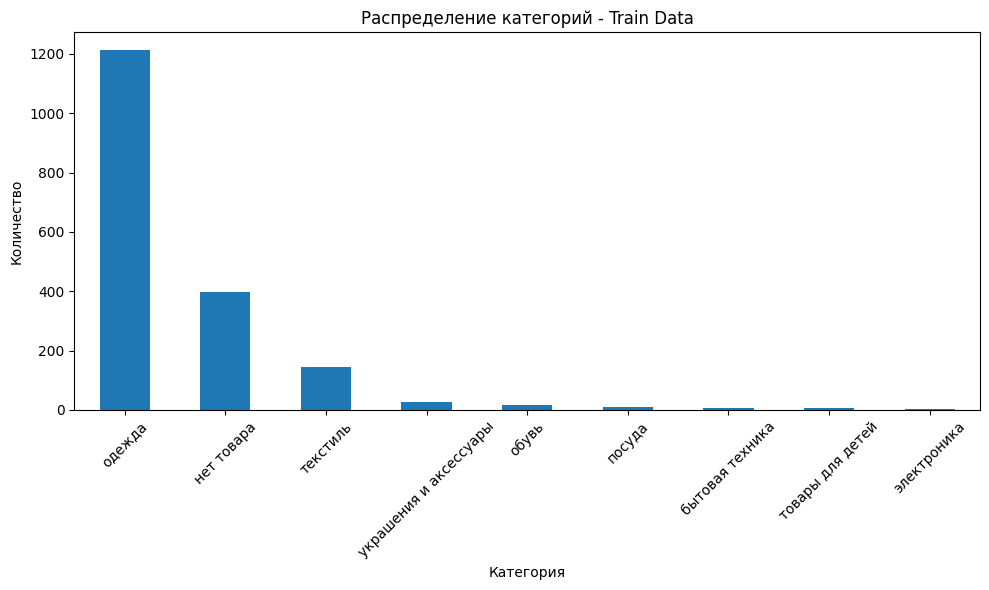


Анализ Test Data:
Общее количество примеров: 7276

Распределение категорий:
predicted_category
одежда                    4794
нет товара                1730
текстиль                   526
украшения и аксессуары      97
обувь                       59
посуда                      29
бытовая техника             24
товары для детей            11
электроника                  6
Name: count, dtype: int64


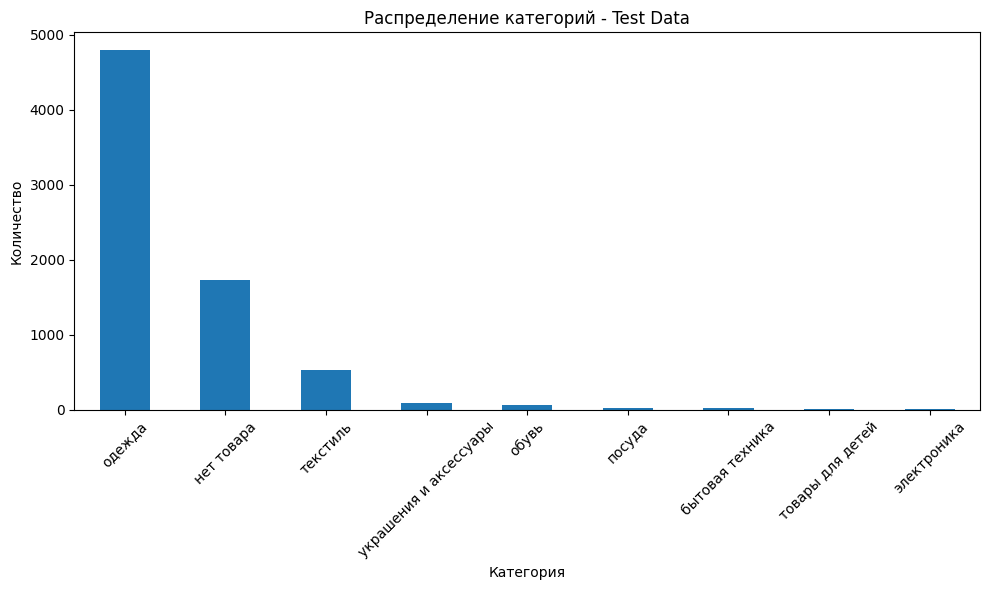

In [ ]:
import matplotlib.pyplot as plt

train_distribution = analyze_labeled_data(train_data, "Train Data")
test_distribution = analyze_labeled_data(test_data, "Test Data")

In [ ]:
def compare_distributions(train_dist, test_dist):
    all_categories = set(train_dist.index) | set(test_dist.index)

    comparison = pd.DataFrame({
        'Train': [train_dist.get(cat, 0) for cat in all_categories],
        'Test': [test_dist.get(cat, 0) for cat in all_categories]
    }, index=list(all_categories))

    comparison['Train_%'] = (comparison['Train'] / comparison['Train'].sum() * 100).round(2)
    comparison['Test_%'] = (comparison['Test'] / comparison['Test'].sum() * 100).round(2)
    comparison['Difference_%'] = (comparison['Test_%'] - comparison['Train_%']).round(2)

    print("Сравнение распределений категорий:")
    print(comparison.sort_values('Train', ascending=False))

    return comparison

In [ ]:
distribution_comparison = compare_distributions(train_distribution, test_distribution)

Сравнение распределений категорий:
                        Train  Test  Train_%  Test_%  Difference_%
одежда                   1212  4794    66.67   65.89         -0.78
нет товара                396  1730    21.78   23.78          2.00
текстиль                  145   526     7.98    7.23         -0.75
украшения и аксессуары     28    97     1.54    1.33         -0.21
обувь                      15    59     0.83    0.81         -0.02
посуда                      8    29     0.44    0.40         -0.04
товары для детей            6    11     0.33    0.15         -0.18
бытовая техника             6    24     0.33    0.33          0.00
электроника                 2     6     0.11    0.08         -0.03
